In [1]:
from PIL import Image
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cv2
import tensorflow as tf
import functools
from data_downloader.get import dado

%matplotlib inline

In [2]:
data = dado("mnist", rm=True)

###################################################
Attempting to download: mnist
###################################################
- Opening url: http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz
- Progress: 100%
- Download Complete!
- Found and verified: mnist-train.gz
- Opening url: http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz
- Progress: 100%
- Download Complete!
- Found and verified: mnist-train-label.gz
- Opening url: http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz
- Progress: 100%
- Download Complete!
- Found and verified: mnist-test.gz
- Opening url: http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz
- Progress: 100%
- Download Complete!
- Found and verified: mnist-test-label.gz
- Extracting mnist-train.gz
- Extracting mnist-train-label.gz
- Extracting mnist-test.gz
- Extracting mnist-test-label.gz
- Moving Files and built training-data.csv
- Moving Files and built test-data.csv
- Removing gz files



In [3]:
def load_data(path, df):
    df = pd.read_pickle(os.path.join(path, df))   
    return df

path = 'data/mnist'

df_train = load_data(path, 'training-data.csv')
df_test = load_data(path, 'test-data.csv')

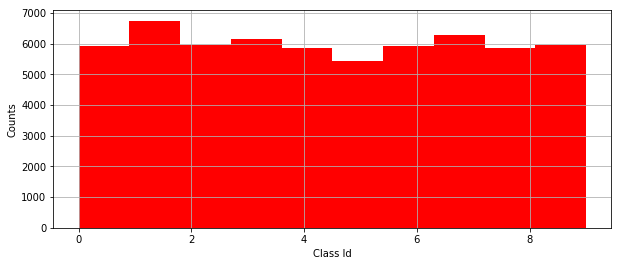

Train dataset size:  60000


In [4]:
plt.figure(figsize=(10,4))
df_train.class_id.hist(bins=10, color='r')
plt.xlabel('Class Id')
plt.ylabel('Counts')
plt.show()
print('Train dataset size: ', len(df_train.class_id))

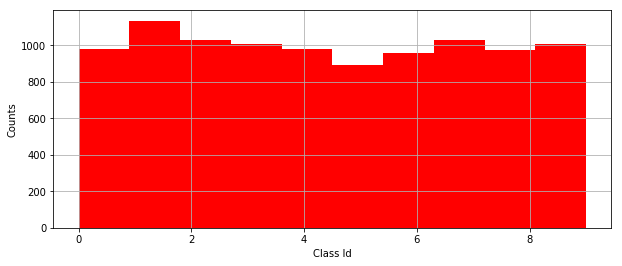

Test dataset size:  10000


In [5]:
plt.figure(figsize=(10,4))
df_test.class_id.hist(bins=10, color='r')
plt.xlabel('Class Id')
plt.ylabel('Counts')
plt.show()
print('Test dataset size: ', len(df_test.class_id))

In [6]:
df_train.head()

,class_id,filename,image
0,5,/home/mauricio/Documents/tutoriales/mnist/data...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1,0,/home/mauricio/Documents/tutoriales/mnist/data...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
2,4,/home/mauricio/Documents/tutoriales/mnist/data...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
3,1,/home/mauricio/Documents/tutoriales/mnist/data...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
4,9,/home/mauricio/Documents/tutoriales/mnist/data...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


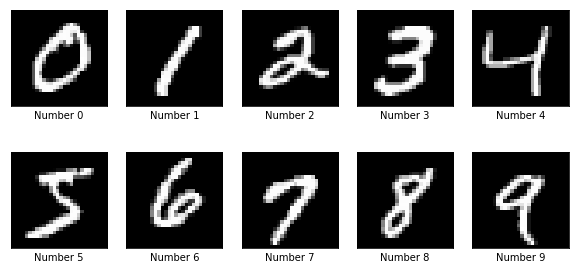

In [7]:
fig=plt.figure(figsize=(10, 10))
rows = 4
cols = 5

for i in range(1, 11):
    img = df_train.image[df_train['class_id']==i-1].values
    ax = fig.add_subplot(rows, cols, i)
    ax.imshow(img[0], cmap='gray')
    ax.tick_params(axis='both', left=False, top=False, right=False, bottom=False, labelleft=False, labeltop=False, labelright=False, labelbottom=False)   
    ax.set_xlabel('Number {}'.format(i-1))
plt.show()

In [8]:
# Training Parameters
learning_rate = 0.001
num_steps = 2000
batch_size = 100
epochs = 5

# Network Parameters
num_classes = 10 
dropout = 0.25

In [9]:
# Neural Network
def conv_net(features, labels, mode):
    
    print()
    print("#######################")
    print("Model")
    print("#######################")
    
    input_layer = tf.reshape(features["image"], [-1, 28, 28, 1]);print(input_layer)

    conv1 = tf.layers.conv2d(input_layer, 32, 5, activation=tf.nn.relu); print(conv1)
    pool1 = tf.layers.max_pooling2d(conv1, 2, 2); print(pool1)

    conv2 = tf.layers.conv2d(pool1, 64, 5, activation=tf.nn.relu); print(conv2)
    pool2 = tf.layers.max_pooling2d(conv2, 2, 2); print(pool2)

    # Flatten the data to a 1-D vector for the fully connected layer
    pool2_flat = tf.contrib.layers.flatten(pool2); print(pool2_flat)

    #fully connected layer
    dense = tf.layers.dense(pool2_flat, 1024, activation=tf.nn.relu); print(dense)

    #dropout
    fc1 = tf.layers.dropout(dense, rate=dropout, training=mode == tf.estimator.ModeKeys.TRAIN); print(fc1)
    logits = tf.layers.dense(fc1, units=num_classes); print(logits)
    print("#######################")
    print()


    predictions = {
        "classes": tf.argmax(input=logits, axis=1),
        "probabilities": tf.nn.softmax(logits, name="softmax_tensor")
    }

    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)

    # Calculate Loss
    onehot_labels = tf.one_hot(indices=tf.cast(labels, tf.int32), depth=num_classes)
    loss = tf.losses.softmax_cross_entropy(
        onehot_labels=onehot_labels, logits=logits)

    # Configure the Training Op
    if mode == tf.estimator.ModeKeys.TRAIN:
        optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
        train_op = optimizer.minimize(loss=loss, global_step=tf.train.get_global_step())
        return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)

    # Add evaluation metrics (for EVAL mode)
    eval_metric_ops = {
        "accuracy": tf.metrics.accuracy(
            labels=labels, predictions=predictions["classes"])}
    return tf.estimator.EstimatorSpec(
        mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)

In [10]:
model = tf.estimator.Estimator(model_fn=conv_net, 
        model_dir="models/mnist")

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'models/mnist', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f0184c56630>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [11]:
def process(df, epochs=epochs, steps=num_steps, batch_size=batch_size):
    
    if epochs:
        steps = int(len(df)/batch_size)*epochs
        
    for _ in range(steps):
        data_set = df.sample(n=batch_size)
        image = list([np.array(Image.open(i)) for i in data_set.filename])
        labels = data_set['class_id'].values
        yield image, labels
          
def input_fn(df):
    dataset = tf.data.Dataset.from_generator(
        functools.partial(process, df=df),
        (tf.float32, tf.float32),
        (tf.TensorShape([batch_size, 28, 28]), tf.TensorShape([batch_size]))
    )
    features, labels = dataset.make_one_shot_iterator().get_next()
    return {'image': features}, labels

In [12]:
# train the model
model.train(input_fn=functools.partial(input_fn, df=df_train))

INFO:tensorflow:Calling model_fn.

#######################
Model
#######################
Tensor("Reshape:0", shape=(100, 28, 28, 1), dtype=float32)
Tensor("conv2d/Relu:0", shape=(100, 24, 24, 32), dtype=float32)
Tensor("max_pooling2d/MaxPool:0", shape=(100, 12, 12, 32), dtype=float32)
Tensor("conv2d_1/Relu:0", shape=(100, 8, 8, 64), dtype=float32)
Tensor("max_pooling2d_1/MaxPool:0", shape=(100, 4, 4, 64), dtype=float32)
Tensor("Flatten/flatten/Reshape:0", shape=(100, 1024), dtype=float32)
Tensor("dense/Relu:0", shape=(100, 1024), dtype=float32)
Tensor("dropout/dropout/mul:0", shape=(100, 1024), dtype=float32)
Tensor("dense_1/BiasAdd:0", shape=(100, 10), dtype=float32)
#######################

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from models/mnist/model.ckpt-3000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving c

In [13]:
# Evaluate the Model
model.evaluate(input_fn=functools.partial(input_fn, df=df_test))

INFO:tensorflow:Calling model_fn.

#######################
Model
#######################
Tensor("Reshape:0", shape=(100, 28, 28, 1), dtype=float32)
Tensor("conv2d/Relu:0", shape=(100, 24, 24, 32), dtype=float32)
Tensor("max_pooling2d/MaxPool:0", shape=(100, 12, 12, 32), dtype=float32)
Tensor("conv2d_1/Relu:0", shape=(100, 8, 8, 64), dtype=float32)
Tensor("max_pooling2d_1/MaxPool:0", shape=(100, 4, 4, 64), dtype=float32)
Tensor("Flatten/flatten/Reshape:0", shape=(100, 1024), dtype=float32)
Tensor("dense/Relu:0", shape=(100, 1024), dtype=float32)
Tensor("dropout/Identity:0", shape=(100, 1024), dtype=float32)
Tensor("dense_1/BiasAdd:0", shape=(100, 10), dtype=float32)
#######################

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-07-06-23:51:02
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from models/mnist/model.ckpt-6000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorf

{'accuracy': 0.9897, 'loss': 0.04863465, 'global_step': 6000}